# Introduction

This week I'm using Julia to explore and analyze some [TidyTuesday](https://github.com/rfordatascience/tidytuesday) data. The dataset this week is [Avatar: The Last Airbender](https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-08-11/readme.md). In this notebook, I conduct some exploratory data analysis and NLP, using the Julia [TextAnalysis](https://juliatext.github.io/TextAnalysis.jl/latest/) package.

I just started with Julia this past week, so I'm focusing on getting the hang of some basic operations.

In [3]:
using CSV
using HTTP
using DataFrames
using Statistics
using Plots

function csv_to_df(address)
    response = HTTP.get(address)
    raw_csv = CSV.File(response.body)
    df = DataFrame(raw_csv)
    df = df[(df[:imdb_rating].!= "NA"), :]
    df.imdb_rating = map(x -> parse(Float64, x), df.imdb_rating)
    return df 
    end 

df = csv_to_df("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-08-11/avatar.csv")

describe(df)

,variable,mean,min
,Symbol,Union…,Any
1,id,6719.21,1
2,book,,Earth
3,book_num,1.99198,1
4,chapter,,Appa's Lost Days
5,chapter_num,10.3097,1
6,character,,Aang
7,full_text,,"""Both""?! [Rapidly turns to face Aang, her expression crazed and her eyes bloodshot.] I'm completely calm!!"
8,character_words,,"""A small fleet of Water Tribe ships."""
9,writer,,Aaron Ehasz


# Exploratory Analysis

In [180]:
book_grouped_df = groupby(df, [:book, :chapter_num])

imdb_book_chp = combine(book_grouped_df, :imdb_rating => mean);

Let's plot some ratings data!

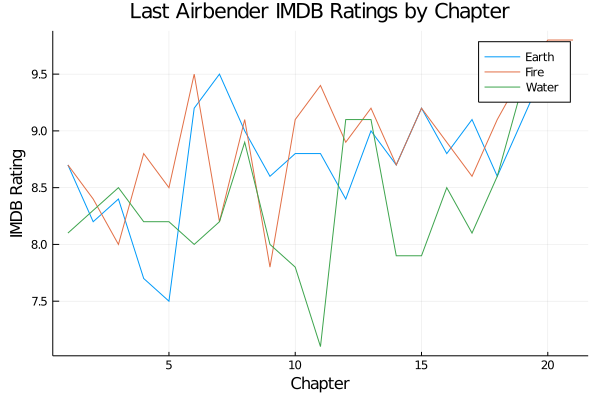

In [309]:
using StatsPlots‹
gr()

@df imdb_book_chp plot(:chapter_num, :imdb_rating_mean, group = :book, 
    title = "Last Airbender IMDB Ratings by Chapter", xlabel = "Chapter", ylabel = "IMDB Rating")

Interesting! Seems like there is a general trend of improving quality within each book as the chapters progress.

# NLP Using TextAnalysis

Let's first build a corpus using the chapters as distinct documents. For this snippet, I'm modifying the example code from [this page](https://juliatext.github.io/TextAnalysis.jl/latest/APIReference/#TextAnalysis.tf_idf-Tuple{DocumentTermMatrix}).

In [307]:
using TextAnalysis

text_book_chapter = groupby(df, [:book, :chapter])
text_book_chapter = combine(text_book_chapter, :full_text => string)

docs = map(x -> StringDocument(x), text_book_chapter.full_text_string)

crps = Corpus(docs)

update_lexicon!(crps)

m = DocumentTermMatrix(crps);

Let's take a look at some of these terms:

In [246]:
m.terms

18122-element Array{String,1}:
 "!"
 "\""
 "'"
 "("
 ")"
 ","
 "-"
 "-?\""
 "-I"
 "-is"
 "."
 "112"
 "180"
 ⋮
 "zone"
 "zoo"
 "zoo."
 "zookeeper"
 "zoom"
 "zoomed"
 "zooming"
 "zooms"
 "–"
 "—"
 "培治龍年七月九日烈火國最黑暗的一天."
 "子白"

Ideally, I would remove this punctuation, but let's keep it simple here and keep the raw tokens. 

Now that we have a Document Term Matrix, we can compute tf idf. 

In [288]:
tfidf_result = tf_idf(m);

Let's find the words most representative of each chapter.

In [306]:
for document in argmax(tfidf_result, dims = 2)
    println(text_book_chapter.book[document[1]], " : ", text_book_chapter.chapter[document[1]],   " - ", m.terms[document[2]])
end

Water : The Boy in the Iceberg - iceberg
Water : The Avatar Returns - Kanna
Water : The Southern Air Temple - Zhao
Water : The Warriors of Kyoshi - Unagi
Water : The King of Omashu - king
Water : Imprisoned - Haru
Water : Winter Solstice, Part 1: The Spirit World - Hei
Water : Winter Solstice, Part 2: Avatar Roku - Shyu
Water : The Waterbending Scroll - pirates
Water : Jet - Jet
Water : The Great Divide - Jin
Water : The Storm - Jee
Water : The Blue Spirit - Blue
Water : The Fortuneteller - Wu
Water : Bato of the Water Tribe - Nyla
Water : The Deserter - Jeong
Water : The Northern Air Temple - balloon
Water : The Waterbending Master - Pakku
Water : The Siege of the North, Part 1 - Yue
Earth : The Avatar State - Fong
Earth : The Cave of Two Lovers - Chong
Earth : Return to Omashu - governor
Earth : The Swamp - vines
Earth : Avatar Day - Chin
Earth : The Blind Bandit - Boulder
Earth : Zuko Alone - Gow
Earth : The Chase - Cuts
Earth : Bitter Work - moose-lion
Earth : The Library - Shi
Ear

For a first pass I'm pretty happy with this. I don't know much about this series to verify that these terms are meaningful, but maybe others can investigate that. At first glance I can see that many of the terms are the chapter titles, which makes sense. 